In [1]:
import tensorflow as tf
print(tf.__version__)

1.14.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [3]:
# Save the input and target variables
print(diabetes_dataset.keys())

data = diabetes_dataset['data']
targets = diabetes_dataset['target']

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [4]:
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean(axis=0))/targets.std()

In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size = 0.1)

In [6]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(397, 10) (45, 10) (397,) (45,)


#### Train a feedforward neural network model

In [7]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation = 'relu', input_shape=(x_train.shape[1],)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    return model
model = get_model()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [9]:
# Compile the model
model.compile(optimizer='adam', loss = 'mse', metrics=['mae'])


In [10]:
# Train the model, with some of the data reserved for validation
history = model.fit(x_train, y_train, epochs = 100, validation_split= 0.15, batch_size = 64, verbose = False)


In [11]:
# Evaluate the model on the test set
model.evaluate(x_test, y_test, verbose=2)


45/45 - 0s - loss: 0.8680 - mean_absolute_error: 0.7617


[0.8680408106909858, 0.7616946]

#### Plot the learning curves

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

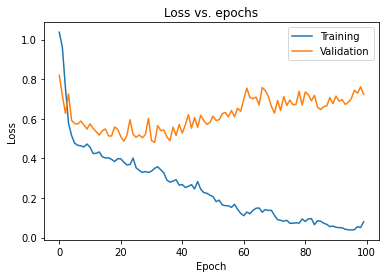

In [13]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [14]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [15]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu", input_shape=(x_train.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer= regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [16]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5,0.3)


In [17]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [18]:
# Train the model, with some of the data reserved for validation
history = model.fit(x_train, y_train, epochs=100, validation_split = 0.15, batch_size = 64, verbose=False)


In [19]:
# Evaluate the model on the test set
model.evaluate(x_test, y_test)


45/45 [==============================] - 0s 1ms/sample - loss: 0.5350 - mean_absolute_error: 0.5768


[0.5349539213710361, 0.57679814]

#### Plot the learning curves

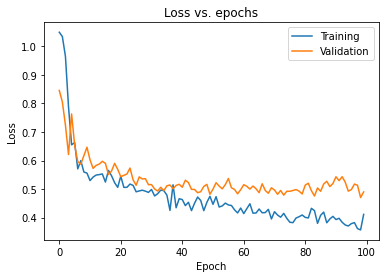

In [20]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [32]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback
class TrainingCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print('Starting training ...')
    def on_epoch_begin(self,epoch, logs=None):
        print(f'Training: Starting epoch {epoch}')
    def on_train_batch_begin(self, batch, logs=None):
        print(f'Training: Starting batch {batch}')
    def on_train_batch_end(self, batch, logs=None):
        print(f'Training: Finished batch {batch}')
    def on_epoch_end(self, epoch, logs=None):
        print(f'Finished epoch {epoch}')
    def on_train_end(self, logs=None):
        print('Finished training')
        
        

In [22]:
# Re-build the model

model = get_regularised_model(1e-5,0.3)


In [33]:
# Compile the model
model.compile(optimizer='adam', loss='mse')


#### Train the model with the callback

In [35]:
# Train the model, with some of the data reserved for validation
model.fit(x_train, y_train, epochs=3, batch_size=128, verbose=False, callbacks = [TrainingCallback()])


Starting training ...
Training: Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
Training: Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
Training: Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished training


In [36]:
# Evaluate the model
model.evaluate(x_test, y_test, verbose=False, callbacks=[TrainingCallback()])


0.5921183202001784

In [37]:
# Make predictions with the model
model.predict(x_test, verbose=False, callbacks=[TrainingCallback()])


array([[-0.38786972],
       [ 0.23592557],
       [-0.44352207],
       [ 0.14758648],
       [-0.4705555 ],
       [-0.84143806],
       [ 1.0104457 ],
       [ 0.33289793],
       [ 0.5477815 ],
       [ 0.6259371 ],
       [ 0.3795962 ],
       [-0.77385455],
       [ 0.52441937],
       [ 0.4525438 ],
       [ 1.4365314 ],
       [-0.77008396],
       [-0.72437143],
       [ 2.1099024 ],
       [ 0.8539167 ],
       [-0.85086364],
       [-0.4867311 ],
       [-0.9742039 ],
       [-0.19509807],
       [ 0.06788876],
       [ 0.11543241],
       [-0.87164015],
       [ 1.3159252 ],
       [-0.67568696],
       [ 0.86500674],
       [-0.75626665],
       [ 0.34371993],
       [-0.69447196],
       [ 1.5333341 ],
       [-0.6773123 ],
       [-0.40288982],
       [ 0.17019783],
       [-0.84185964],
       [-0.7848601 ],
       [-0.08548933],
       [-0.5153967 ],
       [ 1.87715   ],
       [ 0.12438297],
       [-0.5699185 ],
       [ 0.18380783],
       [ 1.3757011 ]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [39]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularised_model.fit(x_train, y_train, epochs=100, validation_split = 0.15, batch_size = 64, verbose=False, callbacks=[tf.keras.callbacks.EarlyStopping()])


In [40]:
# Evaluate the model on the test set
unregularised_model.evaluate(x_test,y_test, verbose=2)


45/45 - 0s - loss: 0.6482


0.6482486327489217

In [53]:
# Re-train the regularised model

regularised_model = get_regularised_model(1e-8,0.2)
regularised_model.compile(optimizer='adam', loss='mse')
reg_history = regularised_model.fit(x_train, y_train, epochs=100, validation_split=0.15, batch_size=64, verbose=False, callbacks=[tf.keras.callbacks.EarlyStopping(patience=4)])

In [54]:
# Evaluate the model on the test set

regularised_model.evaluate(x_test, y_test, verbose=2)

45/45 - 0s - loss: 0.5108


0.5107646233505673

#### Plot the learning curves

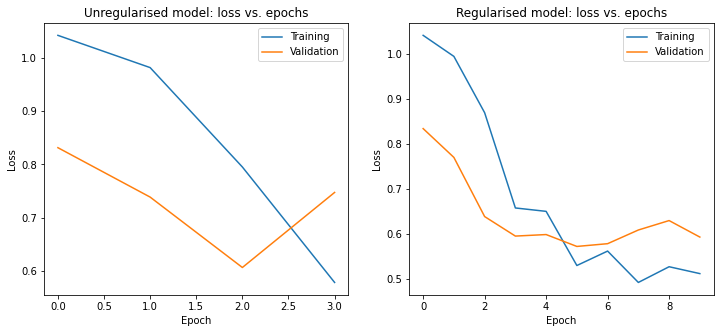

In [55]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()